In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML
from astroML.datasets import fetch_LINEAR_sample
from astropy.coordinates import SkyCoord
import astropy.units as u

# Basic libraries
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm

# CONFIGURATION
# -------------
sns.set_theme(style='white') # setting the theme for plotting
sys.path.insert(0,'../src/')
np.random.seed(42)

# configuring plotting colors
colors = ['#465BBB', '#A82F43', '#3F8FCE', '#7ABBCE', '#3A3865', '#612A37', '#DC5433', '#F29457']
b1 = '#465BBB'
b2 = '#3F8FCE'
b3 = '#7ABBCE'
b4 = '#3A3865'
black1 = '#22212A'
black2 = '#2D1E21'
or1 = '#A82F43'
or2 = '#612A37'
or3 = '#DC5433'
or4 = '#F29457'
muted_colors = sns.set_palette(sns.color_palette(colors))

# configuring fonts for plotting
font = FontProperties()
font.set_family('serif')
font.set_name('Andale Mono')
font.set_style('normal')
#font.set_size('normal')


%matplotlib inline 

In [3]:
plt.rcParams.update({
    'font.serif': 'Andale Mono',
    'font.family': 'serif'
})

In [4]:
#| code-fold: false
# Importing custom libraries
# ----------------------------
sys.path.insert(0,'../src/')
from BE_plotting import*
#from RR_lyrae_params import*
from blazhko_analysis import*

# Results and conclusion

---

*Authors: Ema Donev and dr. Ivezić*

In this notebook we discuss our results and conclude what we have discovered, and our future plans regarding Blazhko analysis.

### Data setup

In [26]:
#| code-fold: false
# DATA
dataLINEAR = fetch_LINEAR_sample(data_home='../inputs') # fetching the data from astroML data library
end = 'ffinal'

# DATA from previous notebook
BE_STARS = pd.read_csv("../outputs/FINAL_BE_CATALOGUE.csv")
rrlyrae = pd.read_csv('../outputs/Lrrlyr_unprocessed.csv')
periodogr = pickle.load(open("../outputs/periodograms_"+end+".pkl", "rb"))
fits = np.load("../outputs/fits_"+end+".npy", allow_pickle=True)
ztf_data = np.load("../outputs/ztf_data_filter"+end+".npy", allow_pickle=True)

In [27]:
BE_STARS.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,period_vs_amp
0,523832,0.372376,0.372384,0.372380,1.000021,251,1.8,1.2,1.9,1.3,...,2.7122,37.3413,0.1528,6.3617,0.17,0.00002,Z,NaN,NaN,NaN
1,1240665,0.632528,0.632522,0.632525,0.999991,468,25.2,3.0,25.4,2.9,...,1.5865,182.3154,0.0570,15.9957,0.00,0.00001,Z,NaN,NaN,NaN
2,1736308,0.555848,0.555843,0.555846,0.999991,372,2.9,1.3,3.0,1.2,...,1.8264,36.6367,0.0529,5.6501,0.11,0.00001,Z,NaN,NaN,NaN
3,2669011,0.591153,0.591151,0.591152,0.999997,450,2.4,1.1,2.3,1.1,...,1.7015,101.2146,0.0751,6.5360,0.16,0.00000,Z,NaN,NaN,NaN
4,2742032,0.629676,0.629692,0.629684,1.000025,514,1.8,0.9,1.9,1.0,...,1.5956,133.2445,0.0602,7.4751,0.34,0.00003,Z,NaN,NaN,NaN


#### Adding the light curve type

In [30]:
LINEAR_RRLR = pd.read_csv('../outputs/Lrrlyr_unprocessed.csv')

In [31]:
LINEAR_RRLR.head()

,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype,LINEARobjectID
0,119.526443,46.962120,1.166,0.369,1.018,0.269,-0.254138,0.619,-0.313,-0.567,16.37,301,1,29848
1,119.712975,52.149574,1.175,0.386,1.100,0.205,-0.191591,0.487,-0.291,-0.879,16.46,284,1,50402
2,119.187241,53.379295,1.123,0.207,1.074,0.210,-0.275092,0.624,-0.547,-0.322,16.54,276,1,62892
3,120.294960,40.932457,1.180,0.237,1.087,0.368,-0.170871,0.753,-0.121,-0.927,15.39,177,1,91437
4,120.124542,40.656620,1.178,-0.145,0.835,0.277,-0.503252,0.550,0.140,-0.650,16.98,222,2,95250


In [32]:
lctype = []

for i in range(len(list(LINEAR_RRLR['LINEARobjectID']))):
    lctype.append((LINEAR_RRLR['LINEARobjectID'][i], LINEAR_RRLR['LCtype'][i]))

be_lctype = []
for i in list(BE_STARS['LINEAR id']):
    for n in lctype:
        if i==n[0]:
            be_lctype.append(n)
print(len(be_lctype))

LCTYPE = [x[1] for x in be_lctype]


136


In [33]:
BE_STARS['LCtype'] = LCTYPE
BE_STARS.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,period_vs_amp,LCtype
0,523832,0.372376,0.372384,0.372380,1.000021,251,1.8,1.2,1.9,1.3,...,37.3413,0.1528,6.3617,0.17,0.00002,Z,NaN,NaN,NaN,2
1,1240665,0.632528,0.632522,0.632525,0.999991,468,25.2,3.0,25.4,2.9,...,182.3154,0.0570,15.9957,0.00,0.00001,Z,NaN,NaN,NaN,1
2,1736308,0.555848,0.555843,0.555846,0.999991,372,2.9,1.3,3.0,1.2,...,36.6367,0.0529,5.6501,0.11,0.00001,Z,NaN,NaN,NaN,1
3,2669011,0.591153,0.591151,0.591152,0.999997,450,2.4,1.1,2.3,1.1,...,101.2146,0.0751,6.5360,0.16,0.00000,Z,NaN,NaN,NaN,1
4,2742032,0.629676,0.629692,0.629684,1.000025,514,1.8,0.9,1.9,1.0,...,133.2445,0.0602,7.4751,0.34,0.00003,Z,NaN,NaN,NaN,1


## Statistical analysis

---

### Distribution of LINEAR Blazhko periods

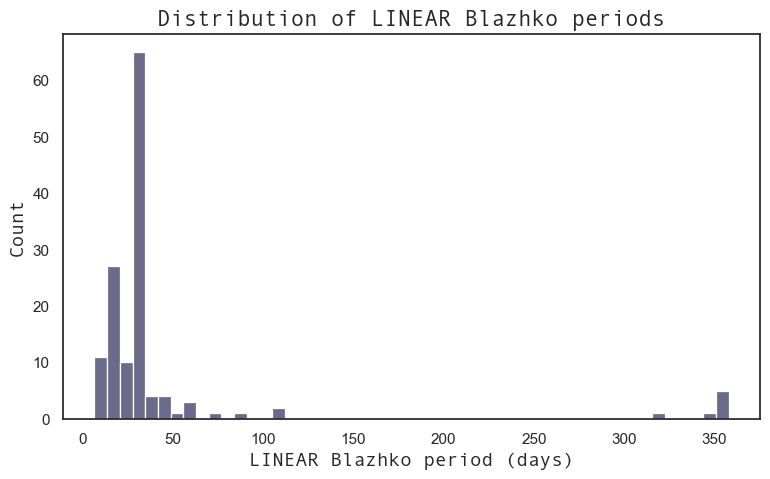

In [11]:
# Blazhko period histogram
# -----

plt.figure(figsize=(9,5))
sns.histplot(data=list(BE_STARS['BlazhkoPeriodL']),color=b4, bins=50) # drawing a histogram of the distribution of measurements
plt.title('Distribution of LINEAR Blazhko periods', fontproperties=font,fontsize=16)
plt.xlabel('LINEAR Blazhko period (days)', fontproperties=font, fontsize=14)
plt.ylabel('Count', fontproperties=font,fontsize=14)
plt.savefig('../img_rsc/BlazhkoperiodL.png', dpi=650)
plt.show()

We can see that most LINEAR light curves have a very small Blazhko period, with only a few of them having a period of more than 300 days.

### Distribution of ZTF Blazhko periods

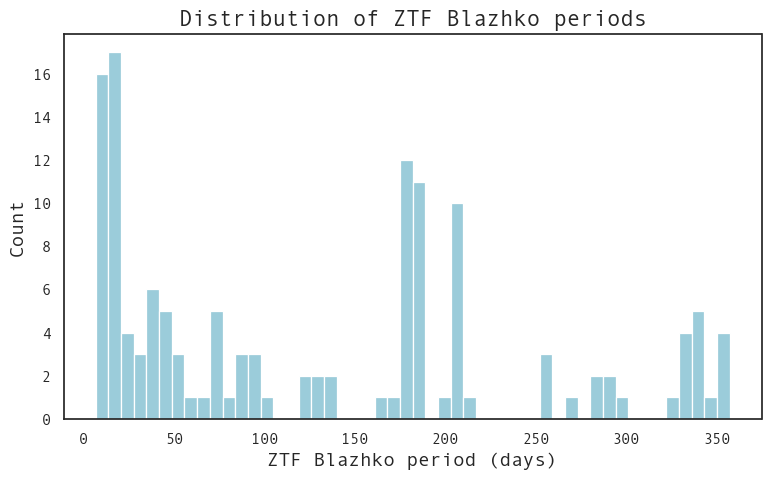

In [18]:
# Blazhko period histogram
# -----

plt.figure(figsize=(9,5))
sns.histplot(data=list(BE_STARS['BlazhkoPeriodZ']),color=b3, bins=50) # drawing a histogram of the distribution of measurements
plt.title('Distribution of ZTF Blazhko periods', fontproperties=font,fontsize=16)
plt.xlabel('ZTF Blazhko period (days)', fontproperties=font, fontsize=14)
plt.ylabel('Count', fontproperties=font,fontsize=14)
plt.savefig('../img_rsc/BlazhkoperiodZ.png', dpi=650)
plt.show()

The ZTF dataset differs slightly, with a more balanced proportion of Blazhko periods, however most stars have a period below 50 days.

### Distribution of the difference between Blazhko frequencies

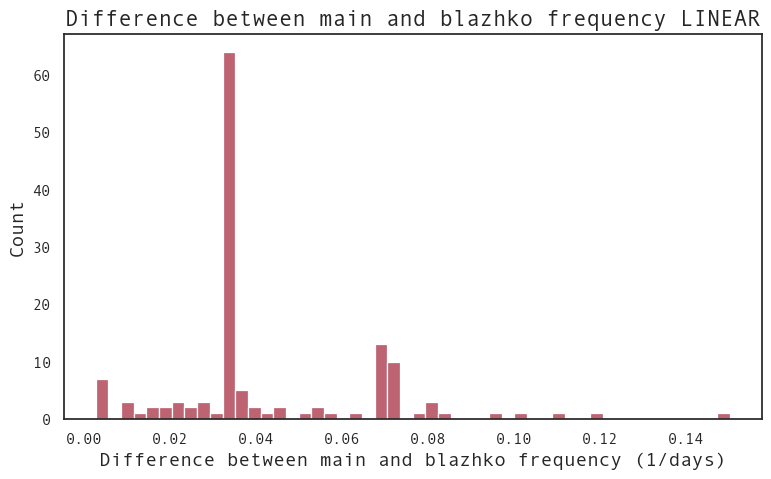

In [19]:
# histogram of frequency differences
# ------
plt.figure(figsize=(9,5))

freq_diff = list(BE_STARS['BlazhkoPeakL'] - BE_STARS['MainPeakL'])

sns.histplot(data=freq_diff,color=or1, bins=50) # drawing a histogram of the distribution of measurements
plt.title('Difference between main and blazhko frequency LINEAR', fontproperties=font,fontsize=16)
plt.xlabel('Difference between main and blazhko frequency (1/days)', fontproperties=font, fontsize=14)
plt.ylabel('Count', fontproperties=font,fontsize=14)
plt.savefig('../img_rsc/BlazhkodiffL.png', dpi=650)
plt.show()

For the LINEAR dataset, the most common difference between the main and blazhko frequency was between 0.02 and 0.04 - the smallness of the number tells us how difficult it is to find the Blazhko effect in stars!

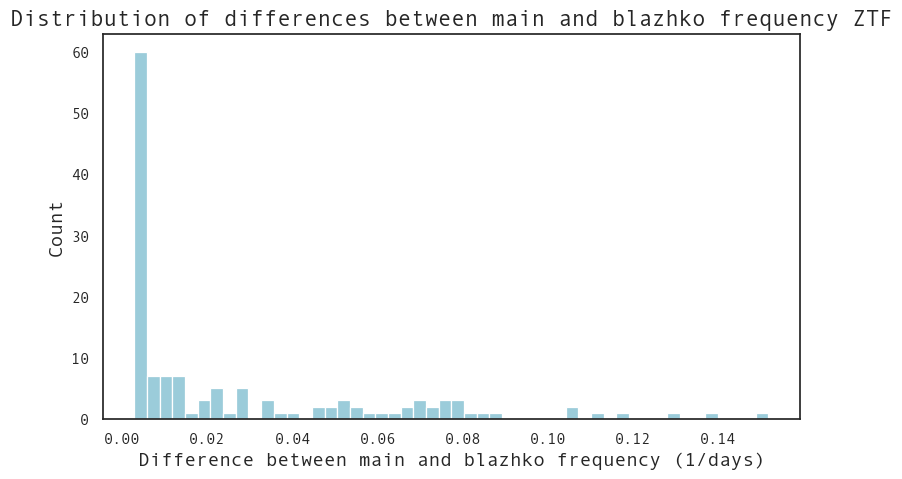

In [21]:
# histogram of frequency differences
# ------
plt.figure(figsize=(9,5))

freq_diff = list(BE_STARS['BlazhkoPeakZ'] - BE_STARS['MainPeakZ'])

sns.histplot(data=freq_diff,color=b3, bins=50) # drawing a histogram of the distribution of measurements
plt.title('Distribution of differences between main and blazhko frequency ZTF', fontproperties=font,fontsize=16)
plt.xlabel('Difference between main and blazhko frequency (1/days)', fontproperties=font, fontsize=14)
plt.ylabel('Count', fontproperties=font,fontsize=14)
plt.savefig('../img_rsc/BlazhkodiffZ.png', dpi=650)
plt.show()

A similar situation is present in the ZTF data, however here the difference is even smaller, between 0.005 and 0.02!

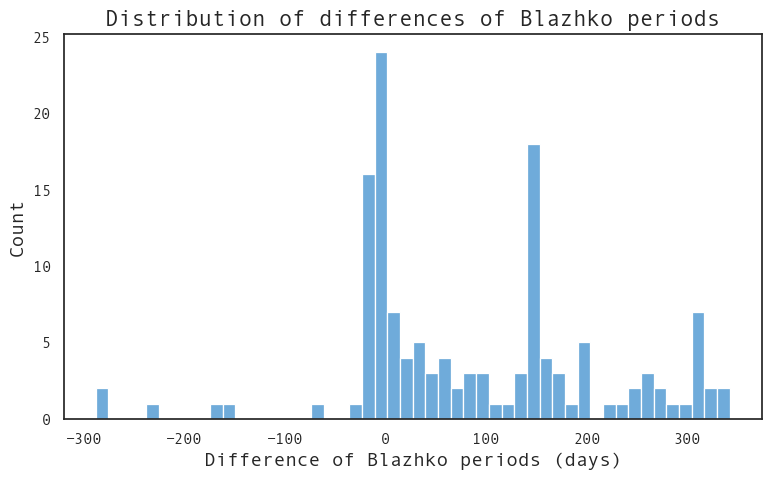

In [22]:
# histogram of frequency differences
# ------
plt.figure(figsize=(9,5))

freq_diff = list(BE_STARS['BlazhkoPeriodZ'] - BE_STARS['BlazhkoPeriodL'])

sns.histplot(data=freq_diff,color=b2, bins=50) # drawing a histogram of the distribution of measurements
plt.title('Distribution of differences of Blazhko periods', fontproperties=font,fontsize=16)
plt.xlabel('Difference of Blazhko periods (days)', fontproperties=font, fontsize=14)
plt.ylabel('Count', fontproperties=font,fontsize=14)
plt.savefig('../img_rsc/Blazhkodiffperiod.png', dpi=650)
plt.show()

Finally, looking at the difference between the ZTF and LINEAR blazhko period, we see how many ZTF periods are actually larger than LINEAR ones.

---

## $\chi^2$ analysis

In [12]:
LC_analysis = pd.read_csv("../outputs/LC_ANALYSIS_"+end+".csv")
LC_analysis.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,MainPeakZ,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score
0,29848,0.557020,0.557040,0.557030,1.000036,301,3.0,1.4,3.3,1.6,...,1.7952,1.7982,333.3333,0.2573,10.0729,0.37,0.00004,NaN,NaN,NaN
1,50402,0.643303,0.643294,0.643298,0.999986,284,0.6,0.7,0.6,0.7,...,1.5545,1.5918,26.8420,0.0027,8.9208,0.21,0.00001,NaN,NaN,NaN
2,62892,0.530776,0.530785,0.530780,1.000017,276,1.1,0.9,1.1,1.0,...,1.8840,1.9433,16.8634,0.0048,13.1609,0.02,0.00002,NaN,NaN,NaN
3,91437,0.674733,0.674737,0.674735,1.000006,177,2.8,1.3,2.8,1.3,...,1.4821,1.4849,355.8719,0.0233,16.1566,0.34,0.00001,NaN,NaN,NaN
4,95250,0.313870,0.313876,0.313873,1.000019,222,0.8,0.8,0.9,0.8,...,3.1860,3.1889,342.4658,0.0028,13.4528,0.02,0.00002,NaN,NaN,NaN


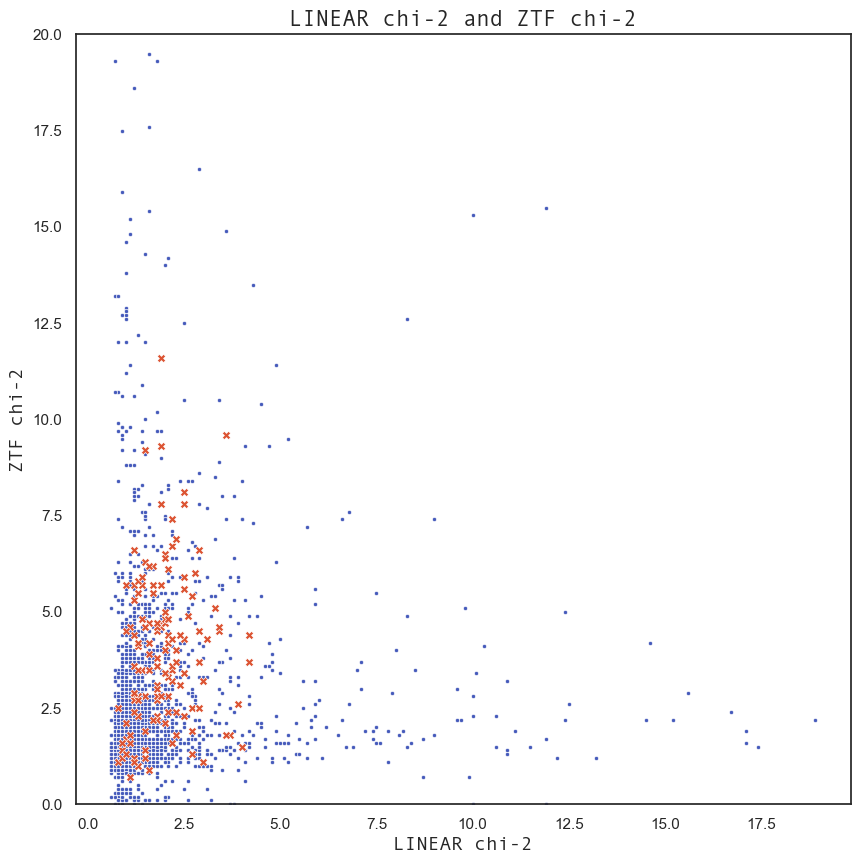

In [13]:
# scatterplot of periods
# ------
plt.figure(figsize=(10,10))

sns.scatterplot(data=LC_analysis, x='L_chi2dofR', y='Zchi2dofR', marker='.', color=b1)
sns.scatterplot(data=BE_STARS, x='L_chi2dofR', y='Zchi2dofR', marker='X', color=or3)
#plt.xlim([0, 1.1])
plt.ylim([0, 20])
plt.title('LINEAR chi-2 and ZTF chi-2', fontproperties=font,fontsize=16)
plt.xlabel('LINEAR chi-2', fontproperties=font, fontsize=14)
plt.ylabel('ZTF chi-2', fontproperties=font,fontsize=14)
plt.savefig('../img_rsc/chi_scatter.png', dpi=650)
plt.show()

Here we notice how most Blazhko stars actually have a larger $\chi^2$ value for the ZTF data rather than LINEAR - an interesting finding!

---

## Proportions of RRab and RRc type stars

In [14]:
lc_counts = BE_STARS['LCtype'].value_counts().reset_index()
lc_counts.columns = ['LCtype', 'Count']

In [15]:
p1 = round(lc_counts['Count'][0]/len(list(BE_STARS['LCtype'])),4)*100
p2 = round(lc_counts['Count'][1]/len(list(BE_STARS['LCtype'])), 4)*100
print(f'The percentage of RRAB stars is {p1}%, while for RRC stars it is {p2}% .')

The percentage of RRAB stars is 71.32%, while for RRC stars it is 28.68% .


In [39]:
for i in range(len(list(BE_STARS['LCtype']))):
    if BE_STARS['LCtype'][i] == 2:
        BE_STARS['LCtype'][i] = 'RRc'
    if BE_STARS['LCtype'][i] == 1:
        BE_STARS['LCtype'][i] = 'RRab'
BE_STARS.head()

/var/folders/t5/p2kd2rtd7bz4dz4p833qfm3w0000gn/T/ipykernel_67740/681684162.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BE_STARS['LCtype'][i] = 'RRc'


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,period_vs_amp,LCtype
0,523832,0.372376,0.372384,0.372380,1.000021,251,1.8,1.2,1.9,1.3,...,37.3413,0.1528,6.3617,0.17,0.00002,Z,NaN,NaN,NaN,RRc
1,1240665,0.632528,0.632522,0.632525,0.999991,468,25.2,3.0,25.4,2.9,...,182.3154,0.0570,15.9957,0.00,0.00001,Z,NaN,NaN,NaN,RRab
2,1736308,0.555848,0.555843,0.555846,0.999991,372,2.9,1.3,3.0,1.2,...,36.6367,0.0529,5.6501,0.11,0.00001,Z,NaN,NaN,NaN,RRab
3,2669011,0.591153,0.591151,0.591152,0.999997,450,2.4,1.1,2.3,1.1,...,101.2146,0.0751,6.5360,0.16,0.00000,Z,NaN,NaN,NaN,RRab
4,2742032,0.629676,0.629692,0.629684,1.000025,514,1.8,0.9,1.9,1.0,...,133.2445,0.0602,7.4751,0.34,0.00003,Z,NaN,NaN,NaN,RRab


---

## Positional analysis

In [40]:
coords = []

for i in range(len(list(LINEAR_RRLR['LINEARobjectID']))):
    coords.append((LINEAR_RRLR['LINEARobjectID'][i], LINEAR_RRLR['ra'][i], LINEAR_RRLR['dec'][i]))

be_coords = []
for i in list(BE_STARS['LINEAR id']):
    for n in coords:
        if i==n[0]:
            be_coords.append(n)
print(len(be_coords))
print(be_coords[:4])

ra = [x[1] for x in be_coords]
dec = [x[2] for x in be_coords]
print(dec[:4])

136
[(523832, 124.601967, 45.734329), (1240665, 170.448395, 3.474343), (1736308, 172.210449, 7.347865), (2669011, 179.175461, -3.469707)]
[45.734329, 3.474343, 7.347865, -3.469707]


In [41]:
#| code-fold: false
# DETERMINING THE RECTASCENSION AND DECLINATION COORDS
rec_ab = []
dec_ab = []
RA = ra
DEC = dec

for i in range(len(list(BE_STARS['LINEAR id']))): # for every id in our dataset
    # look for the index of the current id in the total dataset of stellar attributes
    ra, dec = RA[i], DEC[i] # select rectascension and declination
    rec_ab.append(ra*u.deg) # convert ra into degrees for later conversion
    dec_ab.append(dec*u.deg) # convert dec into degrees for later conversion

print(len(rec_ab), len(dec_ab))

136 136


In [42]:
#| code-fold: false
# CONVERTING THE COORDINATES INTO GALACTIC COORDS

l_ab = []
b_ab = []

for k in range(len(rec_ab)): # for every star in our ab dataset
    # selection of ra and dec coords
    ra = rec_ab[k]
    dec = dec_ab[k]

    # converting them into galactic coordinates
    c = SkyCoord(ra=ra, dec=dec, frame='icrs')
    l = round(c.galactic.l.degree, 3)
    b = round(c.galactic.b.degree, 3)

    # convert the coordinates into a range from -180º to 180º for our projection 
    l_rad = np.radians(l)
    l_rad = np.mod(l_rad + np.pi, 2.0 * np.pi) - np.pi
    b_rad = np.radians(b)

    l_ab.append(l_rad)
    b_ab.append(b_rad)
print(len(l_ab), len(b_ab))

136 136


In [43]:
BE_STARS['lab'] = l_ab
BE_STARS['bab'] = b_ab
BE_STARS.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,period_vs_amp,LCtype,lab,bab
0,523832,0.372376,0.372384,0.372380,1.000021,251,1.8,1.2,1.9,1.3,...,6.3617,0.17,0.00002,Z,NaN,NaN,NaN,RRc,3.040905,0.590340
1,1240665,0.632528,0.632522,0.632525,0.999991,468,25.2,3.0,25.4,2.9,...,15.9957,0.00,0.00001,Z,NaN,NaN,NaN,RRab,-1.799766,1.013879
2,1736308,0.555848,0.555843,0.555846,0.999991,372,2.9,1.3,3.0,1.2,...,5.6501,0.11,0.00001,Z,NaN,NaN,NaN,RRab,-1.842614,1.084966
3,2669011,0.591153,0.591151,0.591152,0.999997,450,2.4,1.1,2.3,1.1,...,6.5360,0.16,0.00000,Z,NaN,NaN,NaN,RRab,-1.440281,0.989130
4,2742032,0.629676,0.629692,0.629684,1.000025,514,1.8,0.9,1.9,1.0,...,7.4751,0.34,0.00003,Z,NaN,NaN,NaN,RRab,-1.468782,1.081825


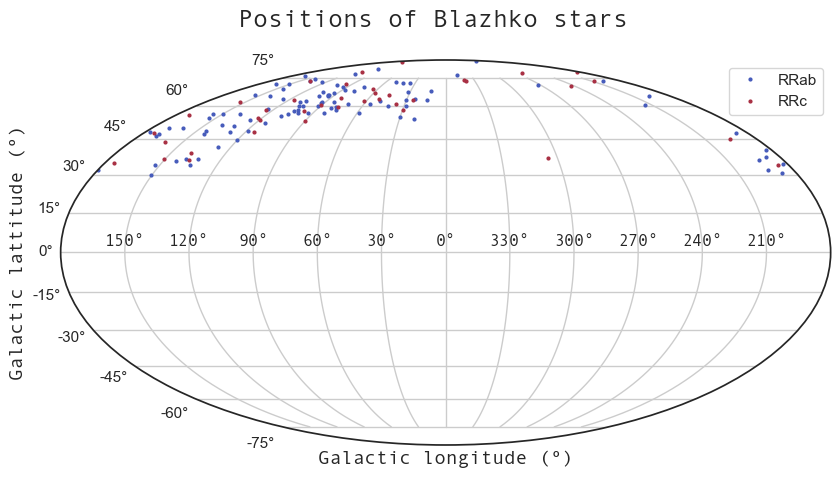

In [45]:
#| code-fold: false
# PLOTTING THE STARS

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='mollweide')
groups = BE_STARS.groupby('LCtype')
for name, group in groups:
    plt.plot(group.lab, group.bab, marker='o', linestyle='', markersize=2, label=name)

ax.grid(True)
fig.suptitle('Positions of Blazhko stars', fontproperties=font,fontsize=18)
ax.set_xticks(np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]))
ax.set_xticklabels(['150°', '120°', '90°', '60°', '30°', '0°', '330°', '300°', '270°', '240°', '210°'], fontproperties=font, fontsize=12)
ax.set_xlabel('Galactic longitude (º)', fontproperties=font, fontsize=14)
ax.set_ylabel('Galactic lattitude (º)', fontproperties=font, fontsize=14)
plt.legend()
plt.savefig('../img_rsc/galactic_coords_blazhko.png', dpi=450)
plt.show()

From analyzing the positions of Blazhko stars, we see that all of them are above the galactic disk, and separated fairly evenly across the sky, with no particular groupings.

---

By comparing our incidence rate of Blazhko stars (4.67%) to other works, we have concluded that our rate is representative of finding Blazhko stars in the field, as well as having a large number of stars at the beginning of our analysis. Surveys like Kepler and OGLE-III have much more precise data with a longer temporal basline, enabling them to find more Blazhko stars which might be hiding with very small modulations. W

We also conclude that by finding 136 out of 239 potential Blazhko stars, the success rate of our algorithm is 57%. From such a high number, we can say that the algorithm is very successful and can be used and refined further for efficient Blazhko star selection!

We discovered that in some Blazhko stars, the effect cannot be detected 10 years later or beforehand. When comparing LINEAR and ZTF data, some pairs have the effect present only for LINEAR or ZTF or both. This could mean that the Blazhko effect isn’t always present and help us discover how the Blazhko effect works! However, since our data is imprecise, it could be that the effect is present, however the telescopes didn't detect such subtle changes. However, this is still an extremely interesting finding worth exploring further.

Finally, when thinking about the future of Blazhko research, this project serves as a very good example of how to automatize the search for Blazhko stars. Instead of visual analysis, a neural network can be trained to firstly categorize variable stars, and then to find Blazhko stars. Also, our algorithms could further be improved by having dynamic scoring mechanisms based on provided data, and other improvements for efficiency and precision. This work can provide a base for finding more Blazhko stars for the future Vera Rubin observatory. The Legacy Survey of Space and Time or LSST will be an excellent survey for studying Blazhko effect! It will have both a long temporal baseline (10 years) and a large number of observations per object, around 825, which is many more data points than the average number for this work. 

In the end, we hope that this work helped in the ongoing research to discover Blazhko effect, and that it inspires more research to be done for more robust finding of such stars.